In [9]:
import kooplearn
import kooplearn.datasets
import matplotlib.pyplot as plt


In [10]:
import logging
import math
from pathlib import Path
from typing import Optional

import numpy as np
import scipy
import scipy.sparse
from scipy.integrate import romb
from scipy.special import binom
from scipy.stats.sampling import NumericalInversePolynomial

from kooplearn._src.utils import topk
from kooplearn.datasets.misc import (
    DataGenerator,
    DiscreteTimeDynamics,
    LinalgDecomposition,
)
import tqdm

from kooplearn.datasets.stochastic import LangevinTripleWell1D,MullerBrownPotential



In [11]:

def return_analytical_forces(vec):
    x = vec[:,0]
    y = vec[:,1]
    forces_x = 0.15*(400*(x-1)*np.exp(-(x-1)**2-10*y**2)+200*x*np.exp(-x**2-10*(y-0.5)**2)-170*(-6.5*2*(0.5+x)+11*(y-1.5))*np.exp(-6.5*(0.5+x)**2+11*(x+0.5)*(y-1.5)-6.5*(y-1.5)**2)+15*(0.7*2*(x+1)+0.6*(y-1))*np.exp(0.7*(1+x)**2+0.6*(1+x)*(y-1)+0.7*(y-1)**2))
    forces_y = 0.15*(4000*np.exp(-(x-1)**2-10*y**2)+2000*(y-0.5)*np.exp(-x**2-10*(y-0.5)**2)-170*(11*(x+0.5)-6.5*2*(y-1.5))*np.exp(-6.5*(0.5+x)**2+11*(x+0.5)*(y-1.5)-6.5*(y-1.5)**2)+15*(0.6*(1+x) +0.7*2*(y-1))*np.exp(0.7*(1+x)**2+0.6*(1+x)*(y-1)+0.7*(y-1)**2))
    return np.concatenate((-forces_x[:,np.newaxis],-forces_y[:,np.newaxis]),axis=1)

In [12]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
scaler = StandardScaler()
scler_samp = MinMaxScaler()
gamma = 10
dt = 0.005
sample = np.loadtxt("/home/tdevergne@iit.local//Documents/generator_learning/muller/vel_bias/COLVAR")[:,1:3]
forces = -np.loadtxt("/home/tdevergne@iit.local/Documents/generator_learning/muller/vel_bias/deriv")[:,2].reshape(sample.shape[0],2)

print(sample.shape)
velocities = np.diff(sample,axis=0)/dt
print(velocities.shape)

total_sample = np.hstack((velocities,sample[1:]))
true_forces = return_analytical_forces(sample)
total_forces = np.hstack((forces[1:]-gamma*velocities ,velocities))

bias = np.loadtxt("/home/tdevergne@iit.local//Documents/generator_learning/muller/vel_bias/COLVAR")[:,-1]
true_forces = return_analytical_forces(sample)


(10000001, 2)
(10000000, 2)


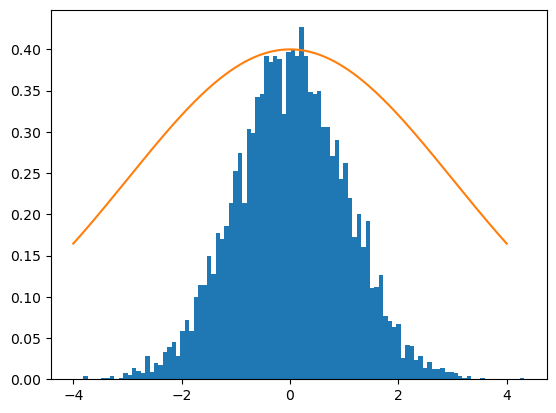

In [13]:
plt.hist(velocities[:700000:100,1],bins=100,density=True)#,sample[:4000000:10,1])
x= np.linspace(-4,4,1000)
plt.plot(x,0.4*np.exp(-x**2/(2*9)))

(10000001, 2)


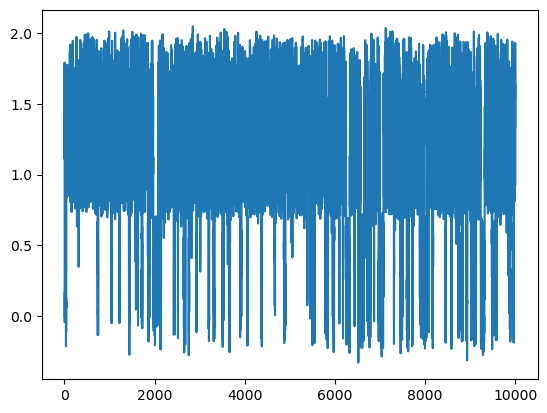

In [14]:
#plt.scatter(sample[::100,0],true_forces[::100,0])
print(sample.shape)
plt.plot(sample[::1000,1])#,sample[:4000000:10,1])

In [15]:
from sklearn.gaussian_process.kernels import RBF
from kooplearn.data import traj_to_contexts
from kooplearn.models import kernel_generator
#0.2 1e-2 1000 PCR
kernel = RBF(length_scale=np.array([3.0,3.0,0.3,0.3])) #0.345 works  well #0.4 best
kernel_no_weights = RBF(length_scale=np.array([5.0,5.0,0.2,0.2])) 
#3.0 3.0 0.3 0.3
print(kernel.length_scale)
#### eta = 1e-4 sigma=5e-3 for weights ####
#### Without weights eta 1e-2, sigma=5e-1, sigma_ker =[5.0,5.0,0.8,0.8], rank=6
eta=1e-4
model = kooplearn.models.kernel_generator.KernelInverseGenerator(kernel, reduced_rank=False, eta=eta, rank=15#15
                                
                                   , tikhonov_reg=5e-3
)
eta_no_weights =5e-4
model_no_weights = kooplearn.models.kernel_generator.KernelInverseGenerator(kernel_no_weights, reduced_rank=False, eta=eta_no_weights, rank=15#15
                                
                                   , tikhonov_reg=9e-3
)

[3.  3.  0.3 0.3]


In [16]:
def force(x):
    return -40*x*(x**2-1)
test=sample[:3]
train_data = traj_to_contexts(total_sample[::2000])
forces_train = traj_to_contexts(total_forces[::2000])

print(train_data.shape)
weights =np.exp(bias/2)
weights_context = traj_to_contexts(weights[1::2000])



(4999, 2, 4)


In [17]:
friction = np.array([2*10.0,2*10.0,0.0,0.0])

#model_correction = model.fit(train_data,forces=(forces_train),friction=friction, weights=weights_context) #np.sqrt(2))
model_no_weights = model_no_weights.fit(train_data,forces=(forces_train),friction=friction, weights=None)

Fitted KernelInverseGenerator model. Lookback length set to 1


In [18]:
#vals_gen_correction, vecs_gen_correction = model_correction.eig(eval_right_on=train_data[:,:1, ...])
vals_gen_no_weights, vecs_gen_no_weights = model_no_weights.eig(eval_right_on=train_data[:,:1, ...])

In [19]:

print(eta - 1/vals_gen_correction)
print(eta_no_weights - 1/vals_gen_no_weights)



NameError: name 'vals_gen_correction' is not defined

###### 

(0.19963508719442727+0j)
(0.0001317819738011131+0j)


/home/tdevergne@iit.local/anaconda3/envs/kooplearn-reborn/lib/python3.9/site-packages/matplotlib/axes/_axes.py:5035: ComplexWarning: Casting complex values to real discards the imaginary part
  accum = np.array(


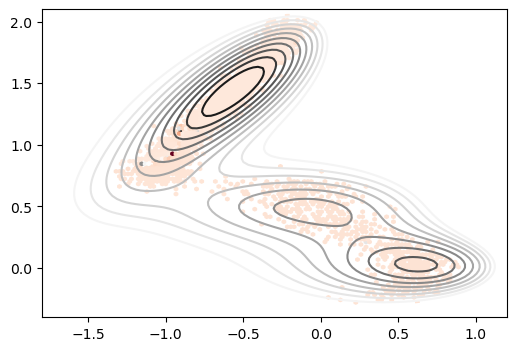

In [ ]:
import numpy as np
from scipy.integrate import solve_bvp
import matplotlib.pyplot as plt
def muller_brown_potential(x, y):
    """Muller-Brown analytical potential"""
    prefactor = 0.15
    A = (-200, -100, -170, 15)
    a = (-1, -1, -6.5, 0.7)
    b = (0, 0, 11, 0.6)
    c = (-10, -10, -6.5, 0.7)
    x0 = (1, 0, -0.5, -1)
    y0 = (0, 0.5, 1.5, 1)
    offset = -146.7

    v = -prefactor * offset
    for i in range(4):
        v += (
            prefactor
            * A[i]
            * np.exp(
                a[i] * (x - x0[i]) ** 2
                + b[i] * (x - x0[i]) * (y - y0[i])
                + c[i] * (y - y0[i]) ** 2
            )
        )
    return v
def plot_isolines_2D(
    function,
    component=None,
    limits=((-1.8, 1.2), (-0.4, 2.1)),
    num_points=(100, 100),
    mode="contourf",
    levels=12,
    cmap=None,
    colorbar=None,
    max_value=None,
    ax=None,
    **kwargs,
):
    """Plot isolines of a function/model in a 2D space."""

    # Define grid where to evaluate function
    if type(num_points) == int:
        num_points = (num_points, num_points)
    xx = np.linspace(limits[0][0], limits[0][1], num_points[0])
    yy = np.linspace(limits[1][0], limits[1][1], num_points[1])
    xv, yv = np.meshgrid(xx, yy)



    z = function(xv, yv)

    if max_value is not None:
        z[z > max_value] = max_value

    # Setup plot
    return_axs = False
    if ax is None:
        return_axs = True
        _, ax = plt.subplots(figsize=(6, 4.0), dpi=100)

    # Color scheme
    if cmap is None:
        if mode == "contourf":
            cmap = "fessa"
        elif mode == "contour":
            cmap = "Greys_r"

    # Colorbar
    if colorbar is None:
        if mode == "contourf":
            colorbar = True
        elif mode == "contour":
            colorbar = False

    # Plot
    if mode == "contourf":
        pp = ax.contourf(xv, yv, z, levels=levels, cmap=cmap, **kwargs)
        if colorbar:
            plt.colorbar(pp, ax=ax)
    else:
        pp = ax.contour(xv, yv, z, levels=levels, cmap=cmap, **kwargs)

    if return_axs:
        return ax
    else:
        return None
print(vecs_gen_correction[:,-1].max())
print(vecs_gen_correction[:,-1].min())

#plt.scatter(np.squeeze(train_data[:,:1, ...]),vecs[:,-4]/vecs[:,-1],label="PCR generator first eigenfunction")
plot_isolines_2D(muller_brown_potential,levels=np.linspace(0,24,12),mode='contour')
plt.hexbin(train_data[:,0, 2],train_data[:,0,3],C=(vecs_gen_no_weights[:,-2])/(vecs_gen_no_weights[:,-1]),cmap='RdGy')
#plt.colorbar()


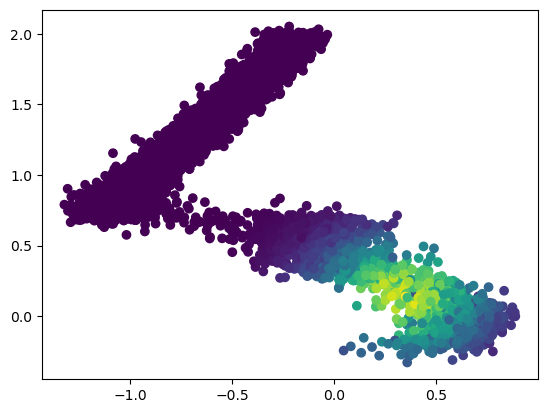

In [ ]:
plt.scatter(total_sample[::1000,2],total_sample[::1000,3],c=kernel(total_sample[::1000])[8,:])

In [ ]:

def compute_cv_on_grid(model1,gen=True,shift=False,num=2):
    limits=((-1.8,1.2),(-0.4,2.1))
    num_points=(100,100)

    xx = np.linspace(limits[0][0],limits[0][1],num_points[0])
    yy = np.linspace(limits[1][0],limits[1][1],num_points[1])
    xv, yv = np.meshgrid(xx, yy)

    z = np.zeros((100,100))
    for i in tqdm.tqdm(range(100)):
        for j in range(100):
            vector = [0.0,0.0,xv[i,j], yv[i,j]]
            xy = np.array(vector).reshape(1,1,4)
            val_gen,vec_gen = model1.eig(eval_right_on=xy)
            if gen== True:
                if shift== False:
                    if abs(vec_gen[:,-1])>1e-4:
                        z[i,j] = ((vec_gen[:,-num])/(vec_gen[:,-1])).real
                    else:
                        z[i,j]=1
                else:
                    z[i,j] = ((1+vec_gen[:,-num])/(1+vec_gen[:,-1])).real
            #grads[i,j]=torch.sum(torch.abs(torch.autograd.grad(z[i,j],xy)[0][0]))
    return xv,yv,z
#xv,yv,cv1= compute_cv_on_grid(model_correction,num=1)
#xv,yv,cv2= compute_cv_on_grid(model_correction,num=2)
#xv,yv,cv3= compute_cv_on_grid(model_correction,num=3)
xv,yv,cv1_w = compute_cv_on_grid(model_no_weights,num=1,shift=False)
xv,yv,cv2_w = compute_cv_on_grid(model_no_weights,num=2,shift=True)
xv,yv,cv3_w = compute_cv_on_grid(model_no_weights,num=3,shift=False)

  0%|          | 0/100 [00:00<?, ?it/s]/tmp/ipykernel_1735539/1522947546.py:18: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  z[i,j] = ((vec_gen[:,-num])/(vec_gen[:,-1])).real
  0%|          | 0/100 [00:00<?, ?it/s]/tmp/ipykernel_1735539/1522947546.py:22: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  z[i,j] = ((1+vec_gen[:,-num])/(1+vec_gen[:,-1])).real
100%|██████████| 100/100 [00:01<00:00, 57.23it/s]


-96.69076631773844


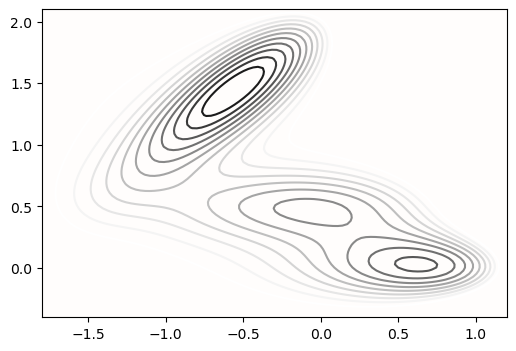

In [ ]:
fig, ax = plt.subplots(figsize=(6,4))

ax.contourf(xv, yv, cv1, levels=100,cmap='RdGy')
plot_isolines_2D(muller_brown_potential,levels=np.linspace(0,24,12),mode='contour',ax=ax)
#plt.hexbin(train_data[:,0, 2],train_data[:,0,3],C=vecs_gen_correction[:,-2]/vecs_gen_correction[:,-1],cmap='RdGy')
#plt.scatter(sample[:,0],sample[:,1])

print(cv2.min())

-96.69076631773844


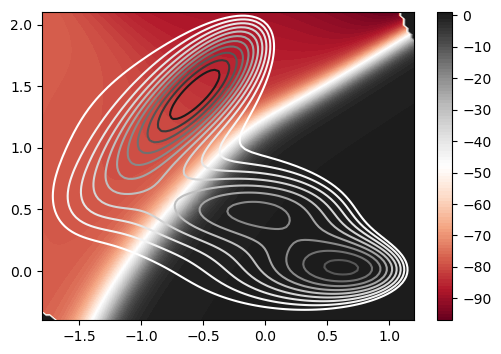

In [ ]:
fig, ax = plt.subplots(figsize=(6,4))
#cv2 = (cv2 - cv2.min())/(cv2.min()-cv2.max())

pp = ax.contourf(xv, yv, cv2, levels=100,cmap='RdGy')
plot_isolines_2D(muller_brown_potential,levels=np.linspace(0,24,12),mode='contour',ax=ax)
plt.colorbar(pp,ax=ax)
#plt.hexbin(train_data[:,0, 2],train_data[:,0,3],C=vecs_gen_correction[:,-2]/vecs_gen_correction[:,-1],cmap='RdGy')
#plt.scatter(sample[:,0],sample[:,1])

print(cv2.min())

-96.69076631773844


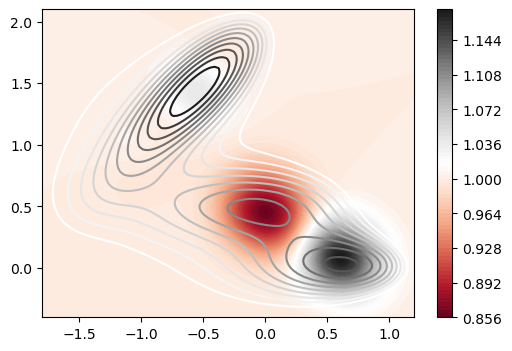

In [ ]:
fig, ax = plt.subplots(figsize=(6,4))
#cv2 = (cv2 - cv2.min())/(cv2.min()-cv2.max())

pp = ax.contourf(xv, yv, cv2_w, levels=100,cmap='RdGy')
plot_isolines_2D(muller_brown_potential,levels=np.linspace(0,24,12),mode='contour',ax=ax)
plt.colorbar(pp,ax=ax)
#plt.hexbin(train_data[:,0, 2],train_data[:,0,3],C=vecs_gen_correction[:,-2]/vecs_gen_correction[:,-1],cmap='RdGy')
#plt.scatter(sample[:,0],sample[:,1])

print(cv2.min())

  0%|          | 0/100 [00:00<?, ?it/s]/tmp/ipykernel_1735539/1522947546.py:18: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  z[i,j] = ((vec_gen[:,-num])/(vec_gen[:,-1])).real
100%|██████████| 100/100 [00:01<00:00, 57.17it/s]


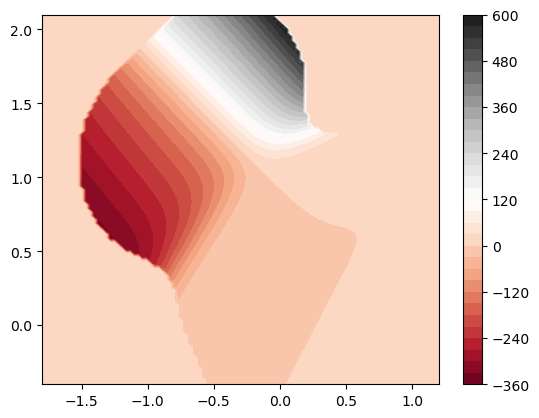

In [ ]:
xv,yv,cv4= compute_cv_on_grid(model_correction,num=3)
plt.contourf(xv, yv, cv4, levels=30,cmap='RdGy')
plt.colorbar()

In [ ]:
print(model_correction.mean_features)

AttributeError: 'KernelInverseGenerator' object has no attribute 'mean_features'